In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, sys

from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.util import img_as_ubyte, img_as_float

In [166]:
origimg_dir = '/home/yuncong/CSHL_data_processed/MD589_thumbnail_aligned_cropped'
orig_filenames = sorted(os.listdir(origimg_dir))
orig_h, orig_w, _ = imread(origimg_dir + '/' + orig_filenames[0]).shape

In [167]:
img_dir = '/home/yuncong/CSHL_data_processed/MD589_thumbnail_aligned_cropped_stereotactic'
filenames = sorted(os.listdir(img_dir))
# h, w, _ = imread(img_dir + '/' + filenames[1]).shape

In [244]:
interaural_center_tb = (51, 342)
pitch_angle = -18.5 # negative for counter-clockise rotation, in degrees

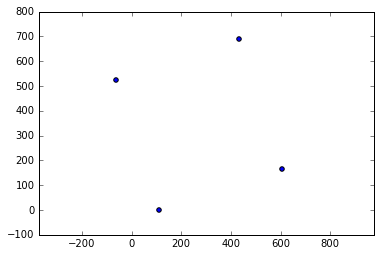

In [103]:
a = np.deg2rad(-pitch_angle)
R = [[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]]

plt.figure()
plt.axis('equal')

# vs = np.array([(645,132),(645,683),(1167,683),(1167,132)])
# for x,y in vs:
#     plt.scatter(x,y, c='r')

# center = (696, 474)

center = interaural_center_tb
new_vs = np.dot(R, (vs-center).T).T + center
    
for x,y in new_vs:
    plt.scatter(x,y)

In [243]:
vs = np.array([(0,0), (0, orig_h-1), (orig_w-1, 0), (orig_w-1, orig_h-1)])
new_vs = np.dot(R, (vs-center).T).T + center

print new_vs

new_vs = new_vs.astype(np.int)

xmin, ymin = new_vs.min(axis=0)
xmax, ymax = new_vs.max(axis=0)

# print xmin, ymin, xmax, ymax
# print xmax-xmin+1, ymax-ymin+1
# print w, h

[[ 111.15368608    1.49077244]
 [ -63.36387495  523.06878281]
 [ 605.23031044  166.80649843]
 [ 430.71274941  688.38450879]]


In [211]:
orig_im = imread(origimg_dir + '/' + orig_filenames[80])

plt.imshow(orig_im)

In [213]:
from skimage.transform import SimilarityTransform, warp

def rotate(image, angle, resize=False, center=None, order=1, mode='constant',
           cval=0, clip=True, preserve_range=False):

    rows, cols = image.shape[0], image.shape[1]

    # rotation around center
    if center is None:
        center = np.array((cols, rows)) / 2. - 0.5
    else:
        center = np.asarray(center)
                
    tform1 = SimilarityTransform(translation=-center)
    tform2 = SimilarityTransform(rotation=np.deg2rad(angle))
    tform3 = SimilarityTransform(translation=center)
    tform = tform1 + tform2 + tform3

    output_shape = None
    if resize:
        # determine shape of output image
        corners = np.array([[1, 1], [1, rows], [cols, rows], [cols, 1]])
        corners = tform(corners - 1)
        minc = corners[:, 0].min()
        minr = corners[:, 1].min()
        maxc = corners[:, 0].max()
        maxr = corners[:, 1].max()
                
        out_rows = maxr - minr + 1
        out_cols = maxc - minc + 1
        output_shape = np.ceil((out_rows, out_cols))
        
        # fit output image in new shape
        translation = -np.asarray((minc, minr))
        tform4 = SimilarityTransform(translation=translation)
        tform = tform + tform4

    return warp(image, tform.inverse, output_shape=output_shape, order=order,
                mode=mode, cval=cval, clip=clip, preserve_range=preserve_range), tform

In [214]:
# orig_im[342-5:342+5, 51-5:51+5] = (255,0,0)

In [215]:
rotated_im, tform = rotate(img_as_float(orig_im), pitch_angle, resize=True, center=interaural_center_tb, cval=0)
rotated_h, rotated_w = rotated_im.shape[:2]

# plt.figure(figsize=(30,30));
# plt.imshow(rotated_im);

In [254]:
interaural_center_tb_shifted = tform(interaural_center_tb)[0].astype(np.int)
print interaural_center_tb_shifted

grid_viz = np.zeros((rotated_h, rotated_w, 4), np.uint8)

# 15.2 um / pixel
micrometers_per_pixel = 15.2
micrometers_per_tick = 250
green_tick_interval_mm = 1000

tick_interval_pixel = micrometers_per_tick / micrometers_per_pixel
green_tick_interval_pixel = green_tick_interval_mm / micrometers_per_pixel

# gray grids are 100 um apart
for c in np.arange(interaural_center_tb_shifted[0], 0, -tick_interval_pixel).astype(np.int):
    grid_viz[:, c, 3] = 255*.1

for c in np.arange(interaural_center_tb_shifted[0], rotated_w, tick_interval_pixel).astype(np.int):
    grid_viz[:, c, 3] = 255*.1
    
for r in np.arange(interaural_center_tb_shifted[1], 0, -tick_interval_pixel).astype(np.int):
    grid_viz[r, :, 3] = 255*.1

for r in np.arange(interaural_center_tb_shifted[1], rotated_h, tick_interval_pixel).astype(np.int):
    grid_viz[r, :, 3] = 255*.1


# green grids are 1 mm apart
for c in np.arange(interaural_center_tb_shifted[0], 0, -green_tick_interval_pixel).astype(np.int):
    grid_viz[:, c, :] = (0,255,0,255)

for c in np.arange(interaural_center_tb_shifted[0], rotated_w, green_tick_interval_pixel).astype(np.int):
    grid_viz[:, c, :] = (0,255,0,255)
    
for r in np.arange(interaural_center_tb_shifted[1], 0, -green_tick_interval_pixel).astype(np.int):
    grid_viz[r, :, :] = (0,255,0,255)

for r in np.arange(interaural_center_tb_shifted[1], rotated_h, green_tick_interval_pixel).astype(np.int):
    grid_viz[r, :, :] = (0,255,0,255)

# red line defines origin (interaural)
grid_viz[:, interaural_center_tb_shifted[0], :] = (255,0,0,255)
grid_viz[interaural_center_tb_shifted[1], :, :] = (255,0,0,255)

[156 473]


In [251]:
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import alpha_blending, display

In [252]:
viz_coord_overlaied = alpha_blending(grid_viz[...,:3], img_as_ubyte(rotated_im), grid_viz[...,3]/255., 1)

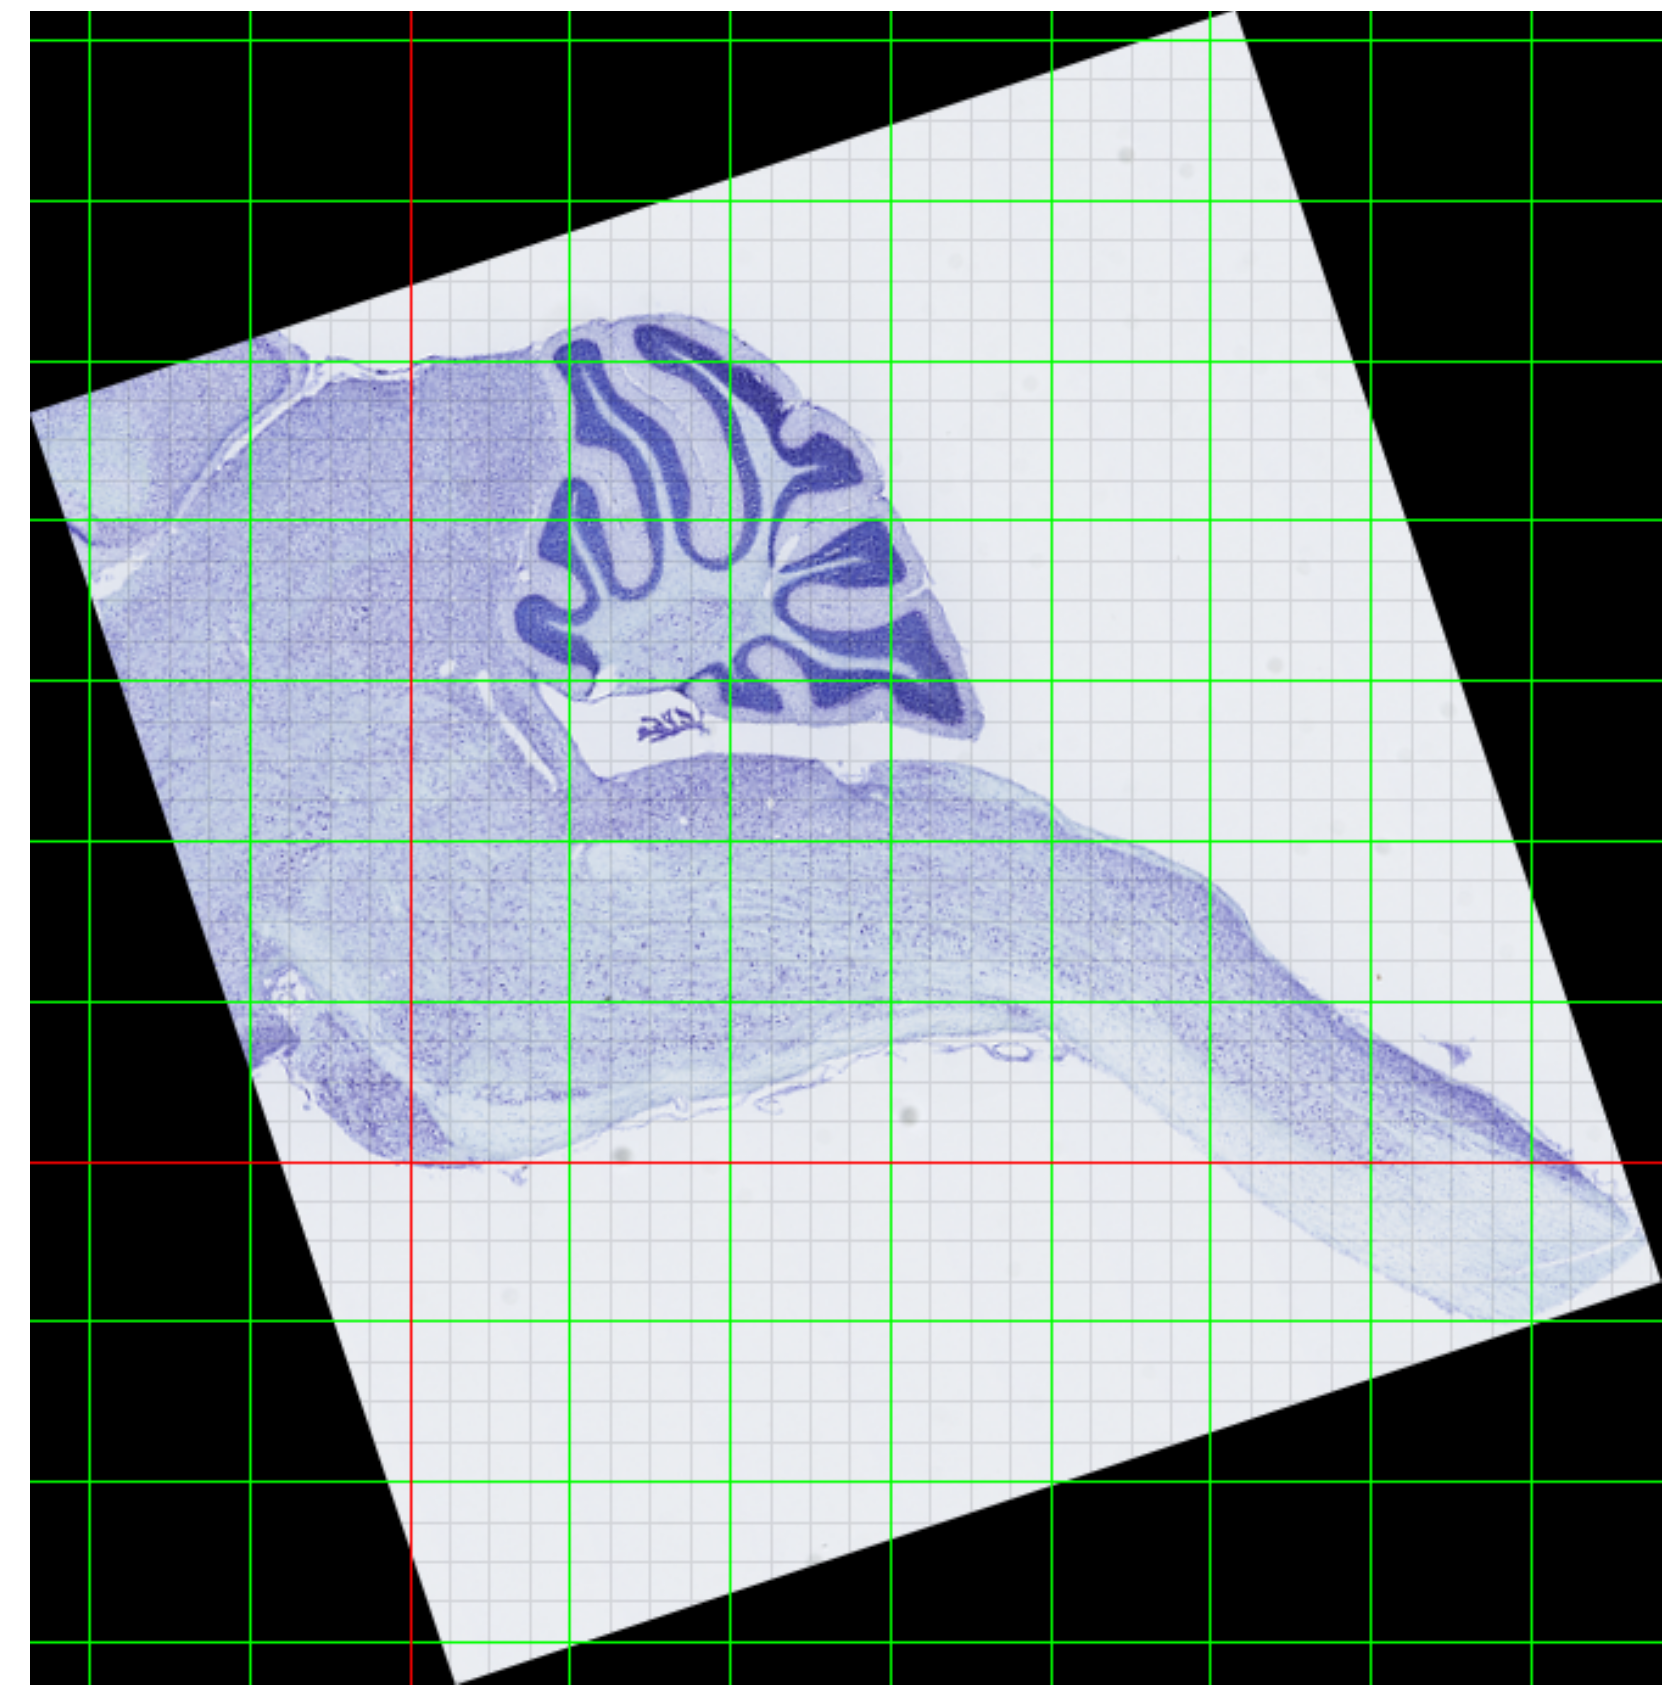

In [253]:
plt.figure(figsize=(30,30));
plt.axis('off');
plt.imshow(viz_coord_overlaied);

In [237]:
zip(range(49, 115), np.linspace(2.64, 0, 114-49+1))

[(49, 2.6400000000000001),
 (50, 2.5993846153846154),
 (51, 2.5587692307692307),
 (52, 2.5181538461538464),
 (53, 2.4775384615384617),
 (54, 2.436923076923077),
 (55, 2.3963076923076922),
 (56, 2.355692307692308),
 (57, 2.3150769230769233),
 (58, 2.2744615384615385),
 (59, 2.2338461538461538),
 (60, 2.1932307692307695),
 (61, 2.1526153846153848),
 (62, 2.1120000000000001),
 (63, 2.0713846153846154),
 (64, 2.0307692307692307),
 (65, 1.9901538461538464),
 (66, 1.9495384615384617),
 (67, 1.9089230769230769),
 (68, 1.8683076923076924),
 (69, 1.8276923076923079),
 (70, 1.7870769230769232),
 (71, 1.7464615384615385),
 (72, 1.705846153846154),
 (73, 1.6652307692307693),
 (74, 1.6246153846153848),
 (75, 1.5840000000000001),
 (76, 1.5433846153846156),
 (77, 1.5027692307692309),
 (78, 1.4621538461538464),
 (79, 1.4215384615384616),
 (80, 1.3809230769230771),
 (81, 1.3403076923076924),
 (82, 1.2996923076923077),
 (83, 1.2590769230769232),
 (84, 1.2184615384615385),
 (85, 1.177846153846154),
 (86,

In [6]:
for f in filenames:
    print f

MD589_0068_thumbnail_aligned_cropped_stereotactic.tif
MD589_0119_thumbnail_aligned_cropped_stereotactic.tif
MD589_0131_thumbnail_aligned_cropped_stereotactic.tif
MD589_0054_thumbnail_aligned_cropped_stereotactic.tif
MD589_0101_thumbnail_aligned_cropped_stereotactic.tif
MD589_0112_thumbnail_aligned_cropped_stereotactic.tif
MD589_0090_thumbnail_aligned_cropped_stereotactic.tif
MD589_0130_thumbnail_aligned_cropped_stereotactic.tif
MD589_0140_thumbnail_aligned_cropped_stereotactic.tif
MD589_0110_thumbnail_aligned_cropped_stereotactic.tif
MD589_0093_thumbnail_aligned_cropped_stereotactic.tif
MD589_0105_thumbnail_aligned_cropped_stereotactic.tif
MD589_0132_thumbnail_aligned_cropped_stereotactic.tif
MD589_0073_thumbnail_aligned_cropped_stereotactic.tif
MD589_0108_thumbnail_aligned_cropped_stereotactic.tif
MD589_0152_thumbnail_aligned_cropped_stereotactic.tif
MD589_0094_thumbnail_aligned_cropped_stereotactic.tif
MD589_0107_thumbnail_aligned_cropped_stereotactic.tif
MD589_0061_thumbnail_aligned